<a href="https://colab.research.google.com/github/not-lain/selective-editor/blob/main/notebooks/selective_editor_manual_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U git+https://github.com/facebookresearch/sam2.git #slow

In [ ]:
!pip install -U supervision loadimg gradio

**restart kernal then proceed**

In [ ]:
import numpy as np
import torch
import supervision as sv
from loadimg import load_img
import gradio as gr
from gradio_client import Client, handle_file

from sam2.sam2_image_predictor import SAM2ImagePredictor

In [ ]:
predictor = SAM2ImagePredictor.from_pretrained("facebook/sam2.1-hiera-large")

sam2.1_hiera_large.pt:   0%|          | 0.00/898M [00:00<?, ?B/s]

In [ ]:
# elon = load_img("https://media.cnn.com/api/v1/images/stellar/prod/221026151430-elon-musk-entering-twitter-hq-1026-screenshot.jpg?c=16x9&q=w_1280,c_fill")
# inputs = [[637, 477]]
# labels = [1]
# input_points = np.array(inputs)
# input_labels = np.array(labels)
# predictor.set_image(elon)
# with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
#   masks, scores, logits = predictor.predict(
#       point_coords=input_points,
#       point_labels=input_labels,
#       multimask_output=False,
#   )
# hidden_mask = load_img(np.squeeze(masks*255)).convert("L")
# mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

# detections = sv.Detections(
#     xyxy=sv.mask_to_xyxy(masks),
#     mask=masks.astype(bool)
# )
# annotated_frame = mask_annotator.annotate(
#     scene=elon.copy(),
#     detections=detections
# )
# annotated_frame

expected output :

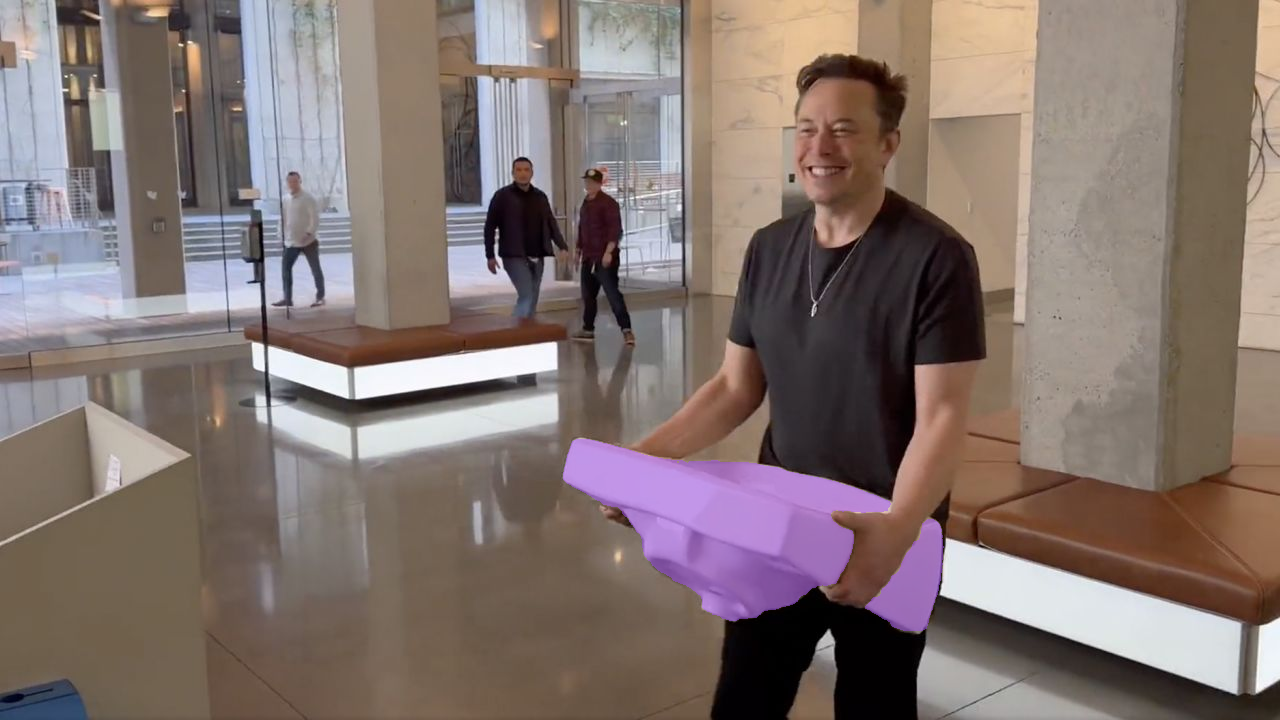

In [ ]:
client = Client("not-lain/flux-inpainting")
car = load_img("https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/truck.jpg")


def process_selection(base_img, selected, legend, hidden_mask, evt : gr.SelectData ):

  # process input
  label = 1 if selected == "add point" else 0
  if legend == None  :
    legend = {"points": [],
              "labels": [],
              "scores" : None,
              "logits" : None,
              }

  legend["points"].append(evt.index)
  legend["labels"].append(label)
  mask_input = np.array(legend["logits"]) if legend["logits"] != None else None

  # sam 2
  input_points = np.array(legend["points"])
  input_labels = np.array(legend["labels"])
  with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    predictor.set_image(base_img)
    masks, scores, logits = predictor.predict(
        point_coords=input_points,
        point_labels=input_labels,
        mask_input=mask_input,
        multimask_output=False,
    )
  # update legend
  legend["scores"] = scores
  legend["logits"] = logits.tolist()
  # hidden mask
  hidden_mask = load_img(np.squeeze(masks*255)).convert("L")
  # supervision for better visuals
  mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

  detections = sv.Detections(
      xyxy=sv.mask_to_xyxy(masks),
      mask=masks.astype(bool)
  )
  annotated_frame = mask_annotator.annotate(
      scene=base_img.copy(),
      detections=detections
  )


  return annotated_frame,legend,hidden_mask

def inpaint(img,mask,prompt,num_inference_steps,guidance_scale):
  out = client.predict(
      image=handle_file(load_img(img,output_type="str")),
      mask=handle_file(load_img(mask,output_type="str")),
      prompt=prompt,
      num_inference_steps=num_inference_steps,
      guidance_scale=guidance_scale,
      api_name="/inpaint"
  )
  out_img = load_img(out)
  return out_img


def upload(img):
  return img, None, None

def reset_fn(base_img,img,legend,hidden_mask):
  return base_img, base_img , None, None



with gr.Blocks(theme="ocean") as demo :
  with gr.Row():
    with gr.Column():
      base_img = gr.Image(value=car,visible = False) # invisible holder of original image before transformation
      hidden_mask = gr.Image(visible = False) # invisible
      img = gr.Image(value=car, interactive=True)
      selected = gr.Radio(["add point", "avoid point"],value="add point",label = "label")
      with gr.Row():
        prompt = gr.Text(label = "inpaint_prompt")
        num_inference_steps = gr.Number(30,label="num_inference_steps")
        guidance_scale = gr.Number(28,label = "guidance_scale")


      with gr.Row():
        reset = gr.Button("Reset",variant="secondary")
        btn = gr.Button("Inpaint",variant="primary")
      legend = gr.JSON(label="legend",visible=False)
    with gr.Column():
      out = gr.Image()

  img.upload(upload,[img],[base_img,hidden_mask,legend])
  img.select(process_selection,[base_img,selected,legend,hidden_mask],[img,legend,hidden_mask])
  btn.click(inpaint,inputs=[base_img,hidden_mask,prompt,num_inference_steps,guidance_scale],outputs=[out])
  reset.click(reset_fn,[base_img,img,legend,hidden_mask],[base_img,img,legend,hidden_mask])

demo.launch(debug=True)

Loaded as API: https://not-lain-flux-inpainting.hf.space ✔
Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://f97d42bd1ab9cf7315.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://f97d42bd1ab9cf7315.gradio.live
